# PREDICCION DE PRECIOS DE AGUACATE EN EEUU





# Enunciado del Problema

- Los datos representan ventas semanales desde 2015 a 2018 a nivel de todos los EEUU. 
- Los datos provienen directamente de las cajas registradoras basados en ventas de aguacate variedad Hass. 
- El precio promedio de los aguacates reflejan el costo por unidad, aún cuando estos se vendan por bolsas. 
- Los códigos (Product Lookup codes ó PLU) en la tabla son solo de aguacates Hass.  No se incluyen otras variedades.

Columnas relevantes en el conjunto de datos:

- Date - la fecha de la observación
- AveragePrice - el precio promedio de una unidad
- type - convencional u orgánico
- year - el año
- Region - la ciudad o región de la observación
- Total Volume - número total de aguacates vendidos
- 4046 - número total de aguacates con PLU 4046 vendidos
- 4225 - número total de aguacates con PLU 4225 vendidos
- 4770 - número total de aguacates con PLU 4770 vendidos



# Importar las librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [32]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Carga de datos

In [4]:
df = pd.read_csv('aguacates_EEUU.csv')

# Explorar el conjunto de datos  

In [5]:
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [6]:
df.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

# Asegurar que estén los datos en orden cronológico

In [7]:
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

Convertimos la columna fecha en tipo fecha

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

In [10]:
df = df.sort_values ('Date')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast
9593,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago
10009,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton
1819,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
9333,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8574,0,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago
9018,0,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral
18141,0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018,SouthCentral
17673,0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California


# Realizar una gráfica de precios promedio vrs fecha

¿Cuál es la tendencia a nivel nacional?

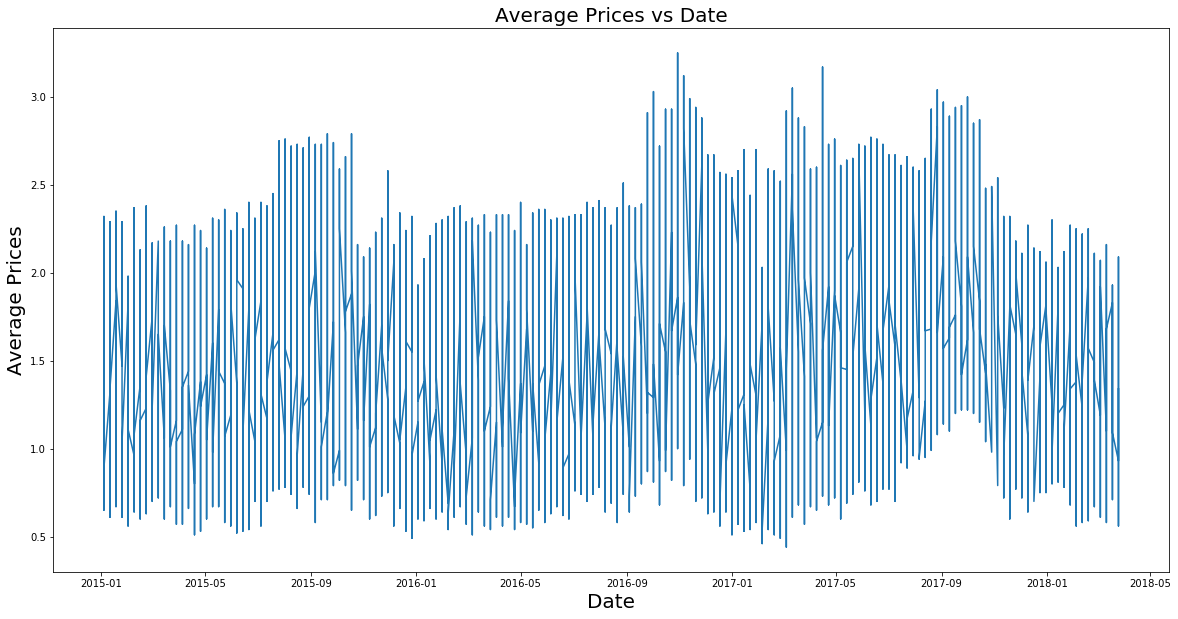

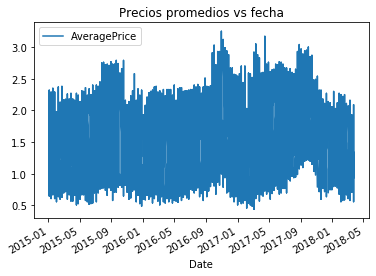

In [9]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'],df['AveragePrice'])
plt.title('Average Prices vs Date',size = 20)
plt.xlabel('Date',size = 20)
plt.ylabel('Average Prices',size = 20)
plt.show()
df.plot(x ='Date', y= 'AveragePrice', title = 'Precios promedios vs fecha')

# Realizar una gráfica de barras para ver el número de regiones

# Realizar una gráfica de barras para ver de qué años se tiene información

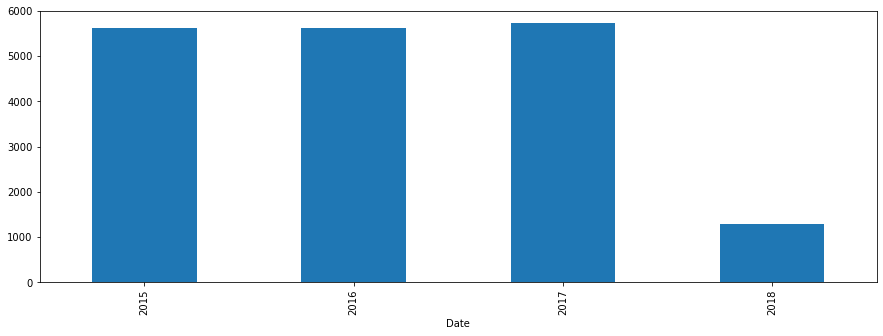

In [10]:
fig = df['Date'].groupby([df["Date"].dt.year]).count().plot(kind="bar",figsize=(15, 5))

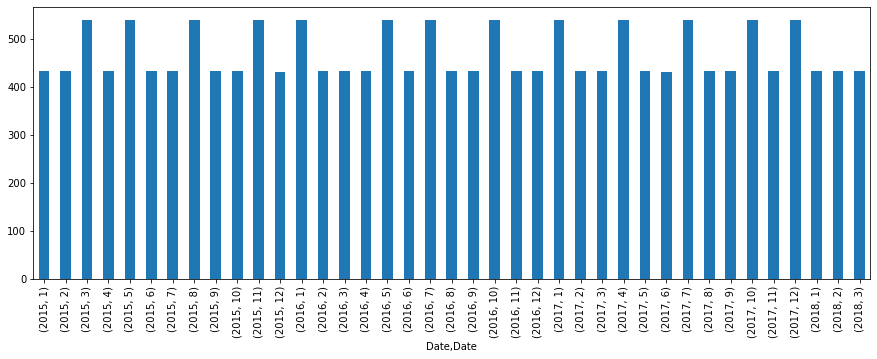

In [11]:
fig = df['Date'].groupby([df["Date"].dt.year, df["Date"].dt.month]).count().plot(kind="bar",figsize=(15, 5))


# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

In [12]:
df['Month'] = pd.DatetimeIndex(df['Date'])
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [13]:
df = df.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})

df = df[['ds','y']]
df.tail(10)

,ds,y
8526,2018-03-25,1.39
17841,2018-03-25,1.75
18057,2018-03-25,1.42
8850,2018-03-25,1.32
17649,2018-03-25,1.74
8574,2018-03-25,1.36
9018,2018-03-25,0.70
18141,2018-03-25,1.42
17673,2018-03-25,1.70
8814,2018-03-25,1.34


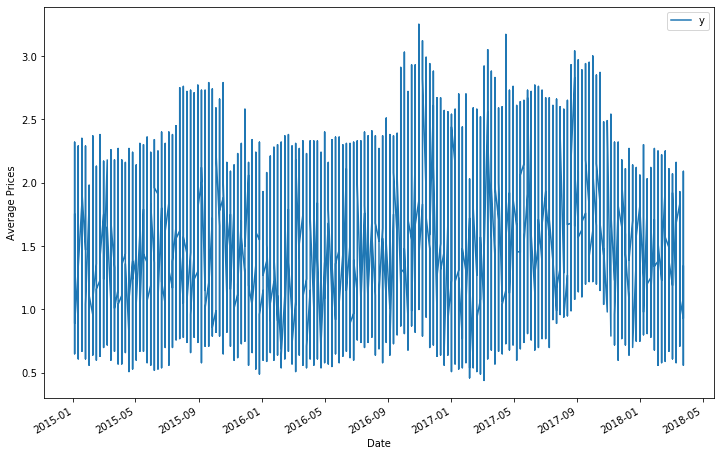

In [14]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

## --------------------------------------------------------- Prophet ---------------------------------------------------------

# Creación y ajuste del modelo

In [15]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95)

In [16]:
mi_modelo.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [21]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [22]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [23]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.381160,0.620851,2.174776
177,2018-12-01,1.225343,0.498171,1.988406
178,2019-01-01,1.107466,0.325326,1.854463
179,2019-02-01,1.047810,0.290942,1.868536
180,2019-03-01,1.082373,0.321458,1.822862


# Graficar datos históricos y pronosticados

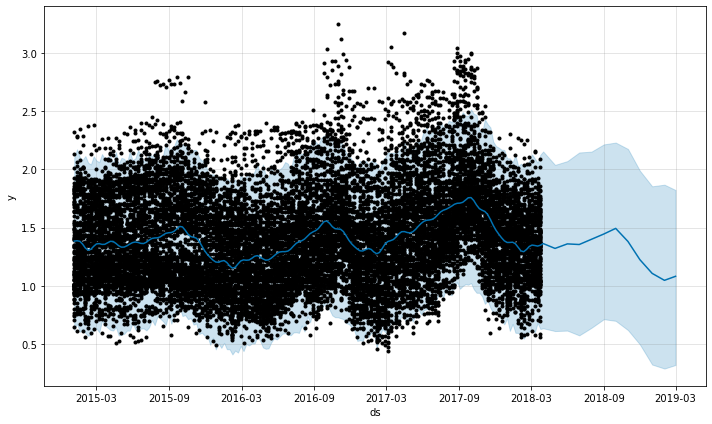

In [25]:
mi_modelo.plot(prediccion,
               uncertainty=True);

# Graficar los componentes del pronóstico

## ------------------------------------------------------ FIN Prophet -----------------------------------------------------

## -------------------------------------------------------- AutoGluon -------------------------------------------------------

# Creación y ajuste del modelo

In [13]:
X_entreno, X_prueba = train_test_split(df, test_size=0.2, random_state=0)

In [14]:
X_entreno

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
15978,18,2017-08-27,1.90,3628.25,1.28,973.22,0.00,2653.75,1313.78,1339.97,0.00,organic,2017,Louisville
14047,34,2016-05-01,1.41,13056.72,1777.72,10850.42,0.00,428.58,428.58,0.00,0.00,organic,2016,Sacramento
13818,13,2016-09-25,1.57,15562.86,2981.79,2886.82,0.00,9694.25,4026.13,5668.12,0.00,organic,2016,Portland
10770,32,2015-05-17,1.88,2730.74,2073.98,46.00,0.00,610.76,610.76,0.00,0.00,organic,2015,Orlando
9067,1,2018-03-18,1.20,71732.63,8952.71,33509.12,83.00,29187.80,9185.93,20001.87,0.00,conventional,2018,Syracuse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,18,2016-08-21,0.87,5682046.61,3137489.03,1105902.29,25630.41,1413024.88,1245189.33,153644.22,14191.33,conventional,2016,SouthCentral
17161,35,2017-04-30,1.31,126586.54,41198.05,8563.75,0.00,76824.74,59357.39,17467.35,0.00,organic,2017,SouthCentral
13869,12,2016-10-02,1.87,10464.63,190.00,4744.03,452.15,5078.45,4848.48,229.97,0.00,organic,2016,RaleighGreensboro
4683,3,2016-12-04,1.00,594246.50,109778.14,143749.16,11803.23,328915.97,325918.13,2557.73,440.11,conventional,2016,Portland


In [15]:
X_prueba

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
3866,18,2016-08-21,1.11,189700.13,90679.27,36441.11,188.93,62390.82,34193.62,26027.20,2170.00,conventional,2016,Jacksonville
10988,42,2015-03-08,1.68,33434.23,3482.60,12593.96,13.73,17343.94,15943.23,1400.71,0.00,organic,2015,Plains
15663,21,2017-08-06,2.11,13548.81,37.14,4371.88,0.00,9139.79,9127.56,12.23,0.00,organic,2017,HartfordSpringfield
6055,15,2017-09-17,2.15,553215.27,59561.15,315414.15,100807.96,77432.01,69984.74,7392.83,54.44,conventional,2017,Chicago
17673,0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,5,2016-11-20,1.46,113766.24,2098.80,35783.89,2138.95,73744.60,37946.97,35797.63,0.00,organic,2016,Midsouth
8749,7,2018-02-04,0.73,5070580.56,2532500.54,965716.73,93806.56,1478556.73,1414064.63,21441.60,43050.50,conventional,2018,LosAngeles
13483,42,2016-03-06,1.79,113859.82,12252.89,30534.74,1756.58,69315.61,41426.65,27888.96,0.00,organic,2016,Northeast
4578,2,2016-12-11,1.21,84144.99,22587.44,22461.37,1185.39,37910.79,33381.50,4529.29,0.00,conventional,2016,Pittsburgh


In [16]:
predictor = TabularPredictor(label="AveragePrice", 
                             problem_type = 'regression', 
                             eval_metric = 'r2').fit(train_data = X_entreno, time_limit = 200, presets = "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221102_001335\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 200s
AutoGluon will save models to "AutogluonModels/ag-20221102_001335\"
AutoGluon Version:  0.5.2
Python Version:     3.9.13
Operating System:   Windows
Train Data Rows:    14599
Train Data Columns: 13
Label Column: AveragePrice
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1960.51 MB
	Train Data (Original)  Memory Usage: 3.24 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique val

# Realizar predicciones

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.950523      22.265415  150.843077                0.000000           0.291548            3       True         11
1      WeightedEnsemble_L2   0.949404      17.731860   93.422956                0.001003           0.571542            2       True          7
2   RandomForestMSE_BAG_L2   0.949146      19.409777  121.755418                1.424388          20.825373            2       True         10
3          LightGBM_BAG_L1   0.948176       7.142726   42.090721                7.142726          42.090721            1       True          4
4          LightGBM_BAG_L2   0.948024      18.536317  112.344948                0.550928          11.414903            2       True          9
5        LightGBMXT_BAG_L2   0.947891      20.290099  118.311253                

C:\Users\carlo\anaconda3\envs\AutoGluon\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.547093097902579,
  'KNeighborsDist_BAG_L1': 0.5709598714210609,
  'LightGBMXT_BAG_L1': 0.9419678649250991,
  'LightGBM_BAG_L1': 0.9481759730319235,
  'RandomForestMSE_BAG_L1': 0.9050201704144655,
  'CatBoost_BAG_L1': 0.5145917410734892,
  'WeightedEnsemble_L2': 0.9494041521983666,
  'LightGBMXT_BAG_L2': 0.9478908096826891,
  'LightGBM_BAG_L2': 0.948024336764

In [18]:
predictor.leaderboard()

                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.950523      22.265415  150.843077                0.000000           0.291548            3       True         11
1      WeightedEnsemble_L2   0.949404      17.731860   93.422956                0.001003           0.571542            2       True          7
2   RandomForestMSE_BAG_L2   0.949146      19.409777  121.755418                1.424388          20.825373            2       True         10
3          LightGBM_BAG_L1   0.948176       7.142726   42.090721                7.142726          42.090721            1       True          4
4          LightGBM_BAG_L2   0.948024      18.536317  112.344948                0.550928          11.414903            2       True          9
5        LightGBMXT_BAG_L2   0.947891      20.290099  118.311253                2.304710          17.381208            2       True          8

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.950523,22.265415,150.843077,0.000000,0.291548,3,True,11
1,WeightedEnsemble_L2,0.949404,17.731860,93.422956,0.001003,0.571542,2,True,7
2,RandomForestMSE_BAG_L2,0.949146,19.409777,121.755418,1.424388,20.825373,2,True,10
3,LightGBM_BAG_L1,0.948176,7.142726,42.090721,7.142726,42.090721,1,True,4
4,LightGBM_BAG_L2,0.948024,18.536317,112.344948,0.550928,11.414903,2,True,9
5,LightGBMXT_BAG_L2,0.947891,20.290099,118.311253,2.304710,17.381208,2,True,8
6,LightGBMXT_BAG_L1,0.941968,9.213988,39.812174,9.213988,39.812174,1,True,3
7,RandomForestMSE_BAG_L1,0.905020,1.374143,10.948519,1.374143,10.948519,1,True,5
8,KNeighborsDist_BAG_L1,0.570960,0.065115,0.116648,0.065115,0.116648,1,True,2
9,KNeighborsUnif_BAG_L1,0.547093,0.101138,0.130606,0.101138,0.130606,1,True,1


                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.950523      22.265415  150.843077                0.000000           0.291548            3       True         11
1      WeightedEnsemble_L2   0.949404      17.731860   93.422956                0.001003           0.571542            2       True          7
2   RandomForestMSE_BAG_L2   0.949146      19.409777  121.755418                1.424388          20.825373            2       True         10
3          LightGBM_BAG_L1   0.948176       7.142726   42.090721                7.142726          42.090721            1       True          4
4          LightGBM_BAG_L2   0.948024      18.536317  112.344948                0.550928          11.414903            2       True          9
5        LightGBMXT_BAG_L2   0.947891      20.290099  118.311253                2.304710          17.381208            2       True          8

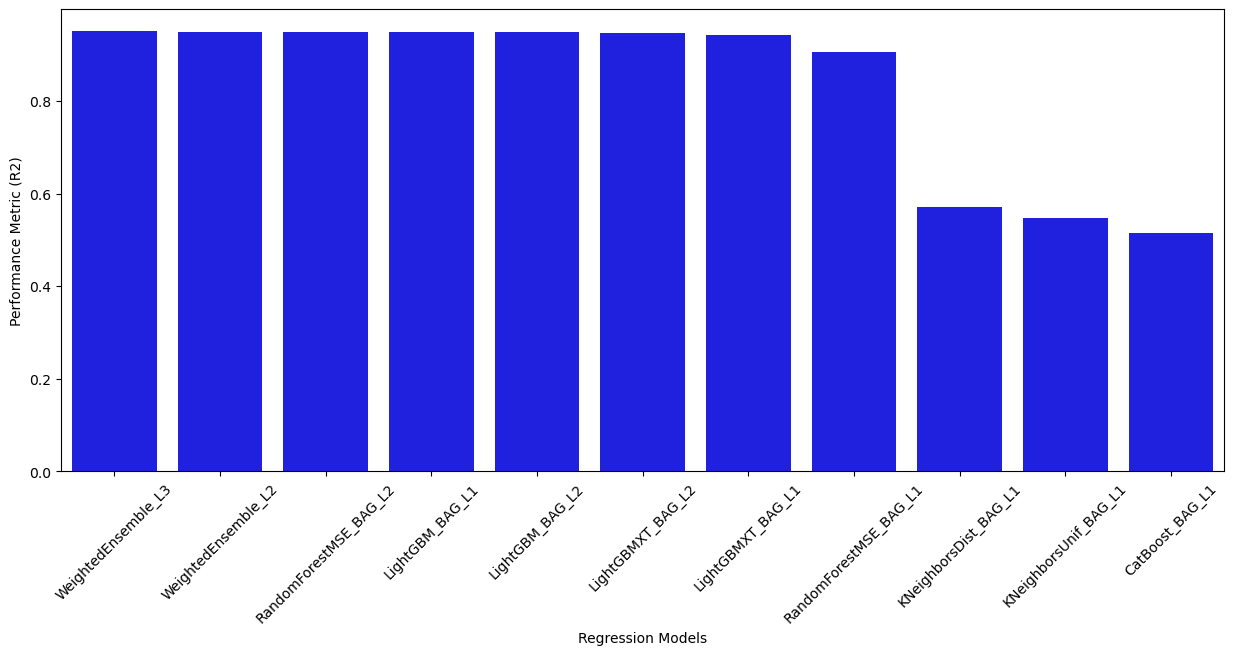

In [21]:
# Inicializar la figura de matplotlib

f, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = "model", y = "score_val", data = predictor.leaderboard(), color = "b")
ax.set(ylabel = "Performance Metric (R2)", xlabel = "Regression Models")
plt.xticks(rotation = 45);

In [22]:
predictor.evaluate(X_prueba)

Evaluation: r2 on test data: 0.9555253022679565
Evaluations on test data:
{
    "r2": 0.9555253022679565,
    "root_mean_squared_error": -0.08521295904676812,
    "mean_squared_error": -0.007261248389506178,
    "mean_absolute_error": -0.059055112380197596,
    "pearsonr": 0.9775949878550358,
    "median_absolute_error": -0.040262284278869576
}


{'r2': 0.9555253022679565,
 'root_mean_squared_error': -0.08521295904676812,
 'mean_squared_error': -0.007261248389506178,
 'mean_absolute_error': -0.059055112380197596,
 'pearsonr': 0.9775949878550358,
 'median_absolute_error': -0.040262284278869576}

In [35]:
# Evaluar el rendimiento de los modelos
# Seleccionar 5 observaciones del conjunto de datos de prueba y generar las predicciones

y_pred = predictor.predict(X_prueba)
print("Predictions:  ", list(y_pred)[:5])

Predictions:   [1.1323285102844238, 1.7096539735794067, 2.250271797180176, 2.0913584232330322, 1.7205021381378174]


In [24]:
X_prueba

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
3866,18,2016-08-21,1.11,189700.13,90679.27,36441.11,188.93,62390.82,34193.62,26027.20,2170.00,conventional,2016,Jacksonville
10988,42,2015-03-08,1.68,33434.23,3482.60,12593.96,13.73,17343.94,15943.23,1400.71,0.00,organic,2015,Plains
15663,21,2017-08-06,2.11,13548.81,37.14,4371.88,0.00,9139.79,9127.56,12.23,0.00,organic,2017,HartfordSpringfield
6055,15,2017-09-17,2.15,553215.27,59561.15,315414.15,100807.96,77432.01,69984.74,7392.83,54.44,conventional,2017,Chicago
17673,0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,5,2016-11-20,1.46,113766.24,2098.80,35783.89,2138.95,73744.60,37946.97,35797.63,0.00,organic,2016,Midsouth
8749,7,2018-02-04,0.73,5070580.56,2532500.54,965716.73,93806.56,1478556.73,1414064.63,21441.60,43050.50,conventional,2018,LosAngeles
13483,42,2016-03-06,1.79,113859.82,12252.89,30534.74,1756.58,69315.61,41426.65,27888.96,0.00,organic,2016,Northeast
4578,2,2016-12-11,1.21,84144.99,22587.44,22461.37,1185.39,37910.79,33381.50,4529.29,0.00,conventional,2016,Pittsburgh


In [27]:
y_prueba = X_prueba['AveragePrice']
y_prueba # valores correctos

3866     1.11
10988    1.68
15663    2.11
6055     2.15
17673    1.70
         ... 
13238    1.46
8749     0.73
13483    1.79
4578     1.21
6866     1.08
Name: AveragePrice, Length: 3650, dtype: float64

Text(0.5, 0, 'Valores reales')

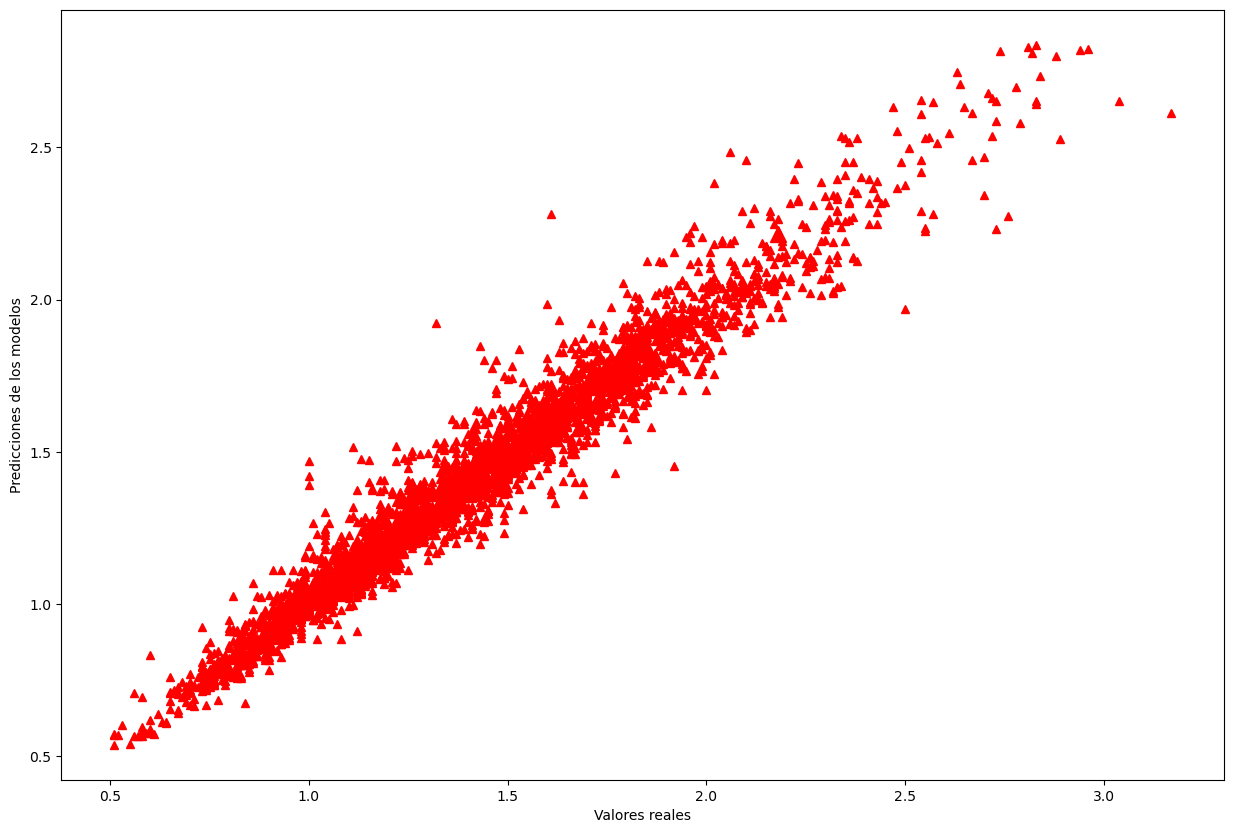

In [28]:
y_predicc = predictor.predict(X_prueba)
plt.figure(figsize = (15, 10))
plt.plot(y_prueba, y_predicc, "^", color = 'r')
plt.ylabel('Predicciones de los modelos')
plt.xlabel('Valores reales')

In [33]:
RMSE = float(format(np.sqrt(mean_squared_error(y_prueba, y_predicc)),'.3f'))
MSE = mean_squared_error(y_prueba, y_predicc)
MAE = mean_absolute_error(y_prueba, y_predicc)
r2 = r2_score(y_prueba, y_predicc)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2) 

RMSE = 0.085 
MSE = 0.007261248389506178 
MAE = 0.059055112380197596 
R2 = 0.9555253022679565


# Pronosticar hacia el futuro un año (365 días)

# Graficar datos históricos y pronosticados

# Graficar los componentes del pronóstico

## ------------------------------------------------------ FIN AutoGluon -----------------------------------------------------

# PARTE 2

### Repetir el ejercicio pero solo con la región oeste "West" de los EEUU

### Leer el archivo de datos

### Por si acaso no están ordenadas las observaciones

# Graficar el precio promedio vs fecha

### ¿Es diferente la tendencia comparado a la tendencia nacional?

# Crear el modelo y ajustarlo con los datos

### Preparar los datos para que sean aceptados por el modelo a usar

# Pronosticar al futuro un año (365 días)

# Graficar datos históricos y pronosticados